# SLC32A1

Heterozyogous variants in SLC32A1 are associated with
two autosomal dominant conditions, [developmental and epileptic encephalopathy-114 (DEE114)](https://omim.org/entry/620774)
and [generalized epilepsy with febrile seizures plus-12 (GEFSP12)](https://omim.org/entry/620755).

In [3]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}.')
print(f"Using gpsea version {gpsea.__version__}.")

Loaded HPO v2024-12-12.
Using gpsea version 0.9.1.


### SLC32A1
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for SLC32A1.

In [2]:
gene_symbol = 'SLC32A1'
mane_tx_id = 'NM_080552.3'
mane_protein_id = 'NP_542119.1' # vesicular inhibitory amino acid transporter

In [4]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.23") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 38 phenopackets
Individuals Processed: 100%|██████████| 38/38 [00:17<00:00,  2.14individuals/s]
Validated under permissive policy
No errors or warnings were found


In [5]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
23,Febrile seizure (within the age range of 3 months to 6 years)
11,Generalized-onset seizure
7,Focal-onset seizure
4,Hypotonia
4,Developmental regression
4,Motor delay
4,Delayed speech and language development
4,Intellectual disability
3,Bilateral tonic-clonic seizure with generalized onset
3,Focal impaired awareness seizure


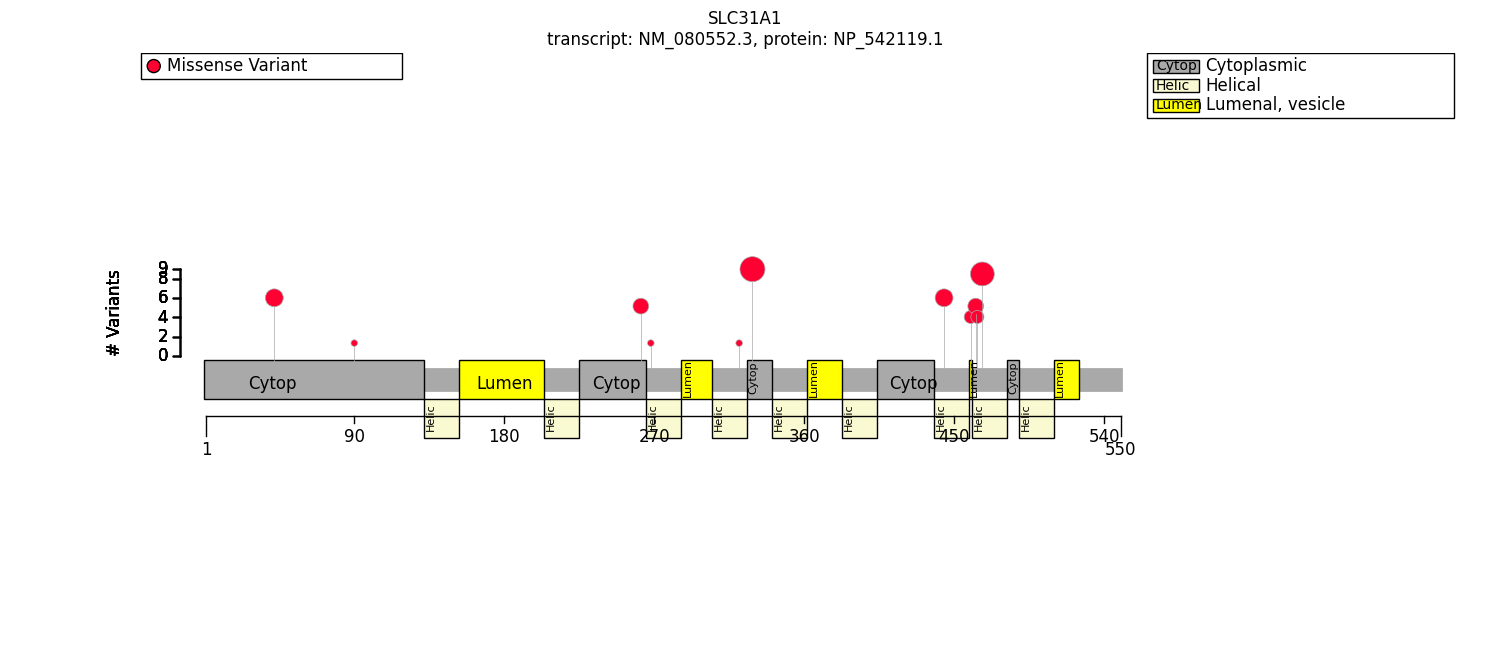

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

protein_meta = ProteinMetadata.from_uniprot_json(
        protein_id=mane_protein_id,
        label="SLC31A1",
        uniprot_json="Q9H598.json",
        protein_length=550,
)

slc32a1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
slc32a1_fig.tight_layout()

# Genotype Phenotype Correlation (GPC) Analysis

No genotype-phenotype correlations were identified in the published literature. All pathogenic variants are missense. Therefore, we will search for the most common variant and for N-terminal vs. C-terminal.

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.model.genome import Region
from gpsea.view import MtcStatsViewer
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.analysis.predicate import protein_region

n_term = protein_region(region=Region(0, 360), tx_id=mane_tx_id)
nterm_clf = monoallelic_classifier(
    a_predicate=n_term,
    b_predicate=~n_term,
    a_label="N term",
    b_label="other"
)

nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=nterm_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(nterm_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,28
HMF03,Skipping term because of a child term with the same individual counts,1
HMF08,Skipping general term,37
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,75


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=nterm_result)

Allele group                                       N term          other  \
                                                    Count Percent  Count   
Febrile seizure (within the age range of 3 mont...   8/15     53%  15/18   
Seizure [HP:0001250]                                17/17    100%  19/19   
Generalized-onset seizure [HP:0002197]                7/7    100%  10/10   
Seizure precipitated by febrile infection [HP:0...    8/8    100%  15/15   

Allele group                                                                   \
                                                   Percent Corrected p values   
Febrile seizure (within the age range of 3 mont...     83%           0.505451   
Seizure [HP:0001250]                                  100%           1.000000   
Generalized-onset seizure [HP:0002197]                100%           1.000000   
Seizure precipitated by febrile infection [HP:0...    100%           1.000000   

Allele group                                                  
                                                    p values  
Febrile seizure (within the age range of 3 mont...  0.126363  
Seizure [HP:0001250]                                1.000000  
Generalized-onset seizure [HP:0002197]              1.000000  
Seizure precipitated by febrile infection [HP:0...  1.000000

In [10]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Febrile seizure (within the age range of 3 mont...  11/17     65%  12/16   
Seizure [HP:0001250]                                17/17    100%  19/19   
Generalized-onset seizure [HP:0002197]                9/9    100%    8/8   
Seizure precipitated by febrile infection [HP:0...  11/11    100%  12/12   

Sex                                                                            \
                                                   Percent Corrected p values   
Febrile seizure (within the age range of 3 mont...     75%                1.0   
Seizure [HP:0001250]                                  100%                1.0   
Generalized-onset seizure [HP:0002197]                100%                1.0   
Seizure precipitated by febrile infection [HP:0...    100%                1.0   

Sex                                                           
                                                    p values  
Febrile seizure (within the age range of 3 mont...  0.707985  
Seizure [HP:0001250]                                1.000000  
Generalized-onset seizure [HP:0002197]              1.000000  
Seizure precipitated by febrile infection [HP:0...  1.000000

In [11]:
from gpsea.analysis.predicate import variant_key

met330thr = variant_key("20_38728050_38728050_T_C") # c.989T>C	p.Met330Thr
met330thr_clf = monoallelic_classifier(
    a_predicate=met330thr,
    b_predicate= ~met330thr,
    a_label='p.Met330Thr',
     b_label= 'Other variant'
)
met330thr_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=met330thr_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=met330thr_result)

Allele group                                       p.Met330Thr          \
                                                         Count Percent   
Seizure [HP:0001250]                                       9/9    100%   
Generalized-onset seizure [HP:0002197]                     3/3    100%   
Febrile seizure (within the age range of 3 mont...         6/9     67%   
Seizure precipitated by febrile infection [HP:0...         6/6    100%   

Allele group                                       Other variant          \
                                                           Count Percent   
Seizure [HP:0001250]                                       27/27    100%   
Generalized-onset seizure [HP:0002197]                     14/14    100%   
Febrile seizure (within the age range of 3 mont...         17/24     71%   
Seizure precipitated by febrile infection [HP:0...         17/17    100%   

Allele group                                                                    
                                                   Corrected p values p values  
Seizure [HP:0001250]                                              1.0      1.0  
Generalized-onset seizure [HP:0002197]                            1.0      1.0  
Febrile seizure (within the age range of 3 mont...                1.0      1.0  
Seizure precipitated by febrile infection [HP:0...                1.0      1.0

# Summary

In [12]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=nterm_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=met330thr_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
)

caption = "No significant correlation identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [13]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
N term,other,4,0
Genotype (A),Genotype (B),Tests performed,Significant tests
p.Met330Thr,Other variant,4,0
Genotype (A),Genotype (B),Tests performed,Significant tests
FEMALE,MALE,4,0


In [14]:
summarizer.process_latex(report=report, protein_fig=slc32a1_fig)

Figure saved to ../../supplement/img/SLC32A1_protein_diagram-draft.pdf
Output to ../../supplement/tex/SLC32A1_summary_draft.tex
